In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [3]:
image_path = '/content/drive/MyDrive/polyp images/Original'
mask_path = '/content/drive/MyDrive/polyp images/Ground Truth'

In [8]:
IMG_HEIGHT, IMG_WIDTH = 256, 256

def load_images(img_folder, mask_folder, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    masks = []

    img_files = sorted(os.listdir(img_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(img_files, mask_files):
        # Load image
        img = load_img(os.path.join(img_folder, img_file), target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)

        # Load mask
        mask = load_img(os.path.join(mask_folder, mask_file), target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

images, masks = load_images(image_path, mask_path)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (612, 256, 256, 3)
Masks shape: (612, 256, 256, 1)


In [20]:
images = np.array(images, dtype=np.float32)
masks  = np.array(masks, dtype=np.float32)

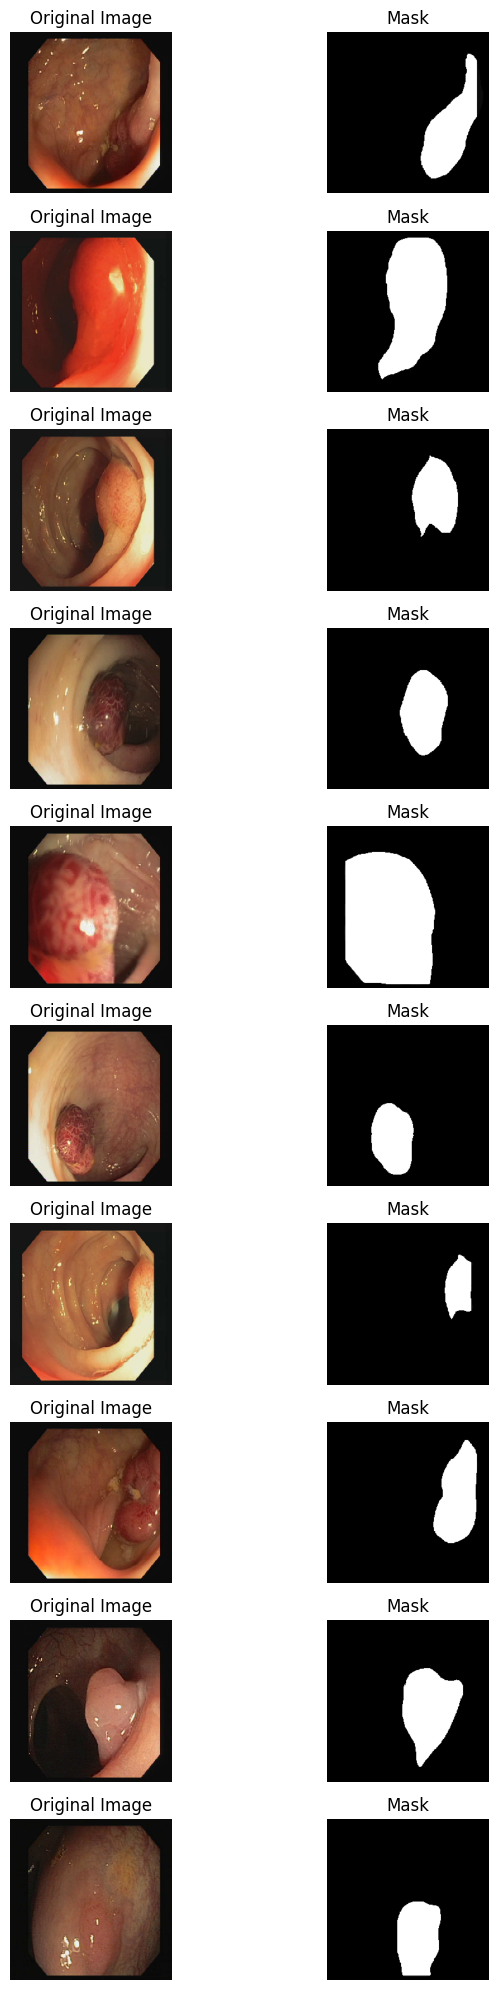

In [10]:
def visualize_dataset(images, masks, n=10):
    idx = random.sample(range(len(images)), n)
    plt.figure(figsize=(8, n * 2))
    for i, j in enumerate(idx):
        # Original image
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(images[j])
        plt.title("Original Image")
        plt.axis('off')

        # mask
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(masks[j].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset(images, masks, n=10)

In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

print("Training:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Training: (495, 256, 256, 3) (495, 256, 256, 1)
Validation: (55, 256, 256, 3) (55, 256, 256, 1)
Test: (62, 256, 256, 3) (62, 256, 256, 1)


In [23]:
# Dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice_coeff

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)


    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)


    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    #  Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    #  Decoder

    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    u6 = layers.BatchNormalization()(u6)


    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    u7 = layers.BatchNormalization()(u7)


    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(u7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    u8 = layers.BatchNormalization()(u8)


    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(u8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    u9 = layers.BatchNormalization()(u9)


    outputs = layers.Conv2D(1, 1, activation='sigmoid')(u9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [24]:
model = unet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred),
    metrics=['accuracy', dice_coef]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [25]:

EPOCHS = 15
BATCH_SIZE = 8


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.6776 - dice_coef: 0.2343 - loss: 0.7357 - val_accuracy: 0.9187 - val_dice_coef: 0.1320 - val_loss: 0.6839
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 53s 483ms/step - accuracy: 0.8823 - dice_coef: 0.3220 - loss: 0.5819 - val_accuracy: 0.9187 - val_dice_coef: 0.1141 - val_loss: 0.6083
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - accuracy: 0.9213 - dice_coef: 0.3934 - loss: 0.4979 - val_accuracy: 0.9187 - val_dice_coef: 0.1042 - val_loss: 0.5956
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - accuracy: 0.9334 - dice_coef: 0.4367 - loss: 0.4411 - val_accuracy: 0.9187 - val_dice_coef: 0.0942 - val_loss: 0.5937
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.9407 - dice_coef: 0.4560 - loss: 0.4193 - val_accuracy: 0.9187 - val_dice_coef: 0.0851 - val_loss: 0.5983
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - accuracy: 0.9582 - dice_coef: 0.5389 - loss: 0.3433 - val_accuracy: 0.9184 - val_d

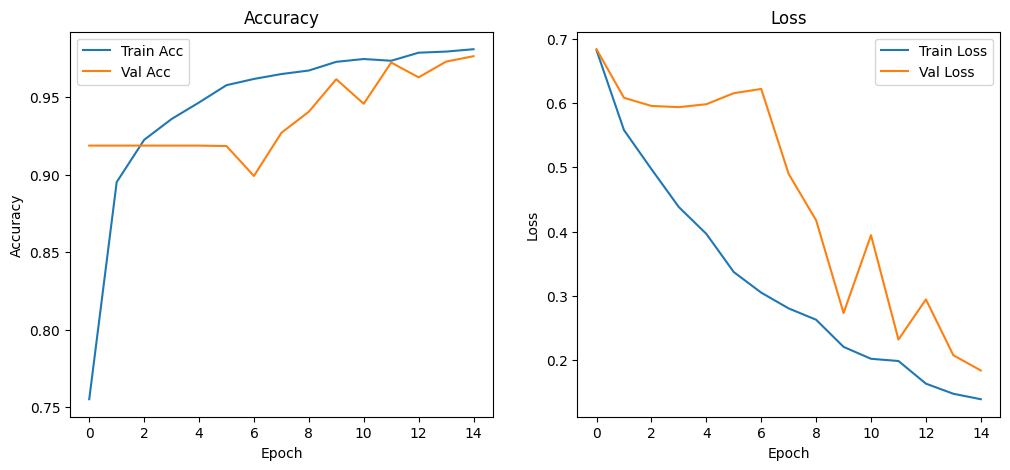

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_dice = test_results[2]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - accuracy: 0.9790 - dice_coef: 0.8362 - loss: 0.1515
Test Loss: 0.1582
Test Accuracy: 0.9790
Test Dice Coefficient: 0.8298


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


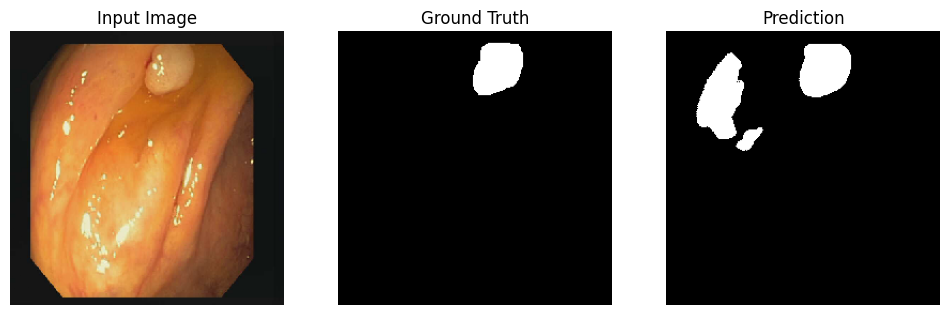

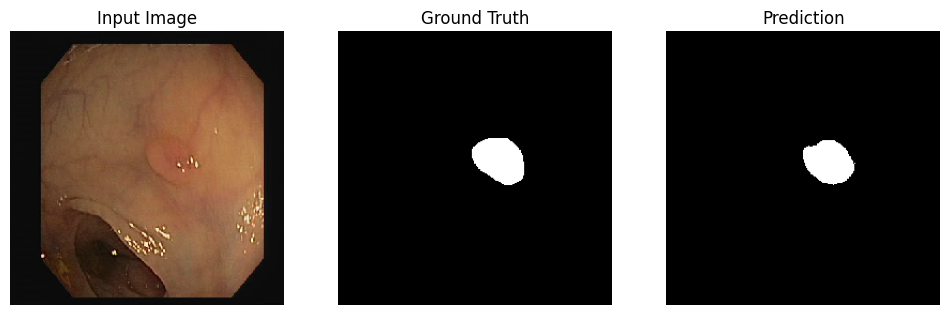

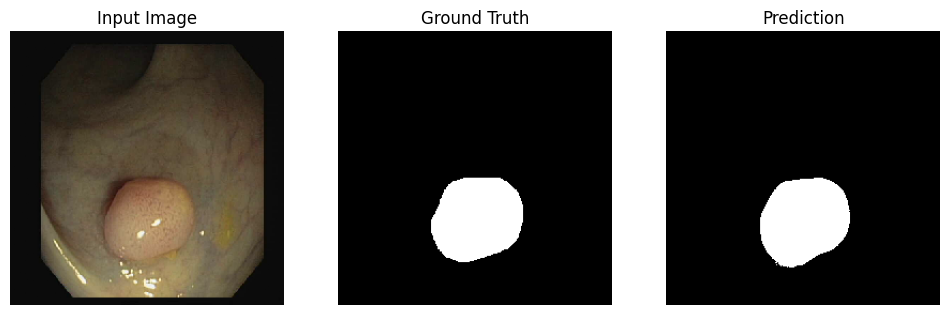

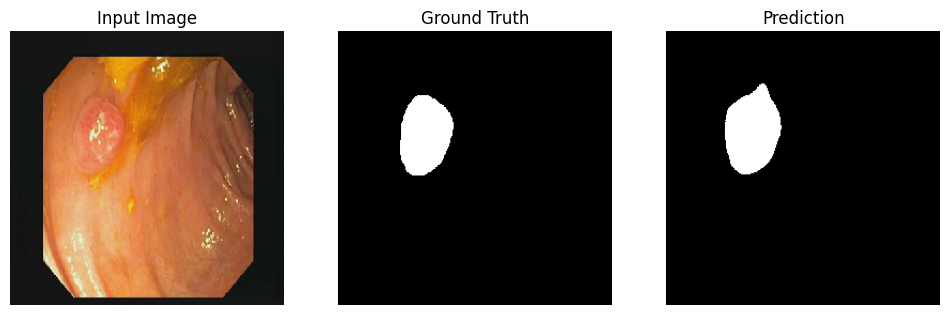

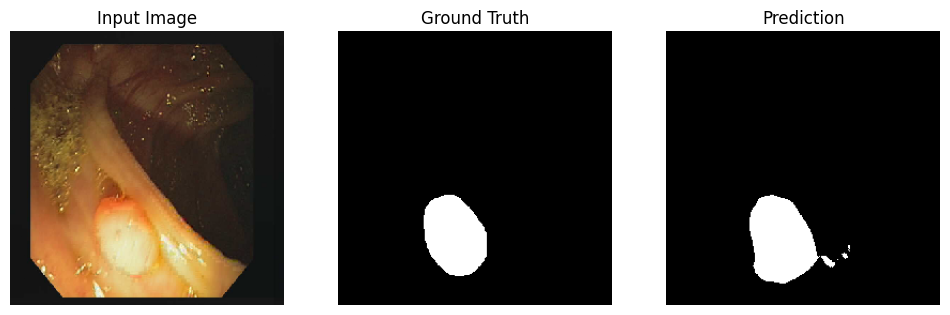

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(model, X, y, n=10, threshold=0.5):

    preds = model.predict(X[:n])

    for i in range(n):
        # Binarize prediction
        pred_mask = (preds[i].squeeze() > threshold).astype(np.float32)

        plt.figure(figsize=(12,4))

        # Input image
        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title('Input Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(1,3,2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.show()


visualize_prediction(model, X_test, y_test, n=5, threshold=0.5)